In [2]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

<IPython.core.display.Javascript object>

In [3]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
from copy import copy
import warnings
warnings.filterwarnings('ignore')
# make matplotlib pdf-s text recognizable by evil-Adobe
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
from more_itertools import chunked
# import all relevant func and modules from a companion .py file
from supp_lib import *
# import all samples as dictionary ...
from samples import *

In [5]:
import upsetplot

#### get some gene annotation the way we used it in the stackups (one from RefSeq, from HiGlass ...)

In [6]:
genes_df = pd.read_csv(
    "./gene_annot_data/hg19/geneAnnotationsExonUnions.bed",
    sep="\t",
    header=None,
    names = ["chr",
            "txStart",
            "txEnd",
            "geneName",
            "citationCount",
            "strand",
            "union_geneId", # "refseqId",
            "geneId",
            "geneType",
            "geneDesc",
            "cdsStart",
            "cdsEnd",
            "exonStarts",
            "exonEnds"]
)
genes_df.head()

### we'll be removing duplicated genes because they're likely unamppable and/or harder to deal with anyways ...
### there are of course expections, but will do it anyways:
geneId_grp = genes_df.groupby("geneId")
genes_df = geneId_grp.first()[geneId_grp.size() == 1].reset_index()

#### Get expression data measured in TPMs

In [7]:
# #RSEM for siRNA (and 44 and 442)
# !scp ghpcc:/nl/umw_job_dekker/users/av90w/RNAseq/data/siRNA/report2546/rsem/mergedRSEM/merged_TPM_genes.tsv ./merged_TPM_genes_si.tsv
# #RSEM for clones (and 44 and 442)
# !scp ghpcc:/nl/umw_job_dekker/users/av90w/RNAseq/data/siRNA/report2547/rsem/mergedRSEM/merged_TPM_genes.tsv ./merged_TPM_genes_mut.tsv

In [8]:
de_samples = {
# mutants DE genes
"mutCtrl-IAA_mutCtrl-NT":"./DE-genes/up+down-AAVS1NT-AAVS1-IAA",
"mutDDX55-IAA_mutCtrl-NT":"./DE-genes/up+down-AAVS1NT-DDX55-IAA",
"mutDDX55-NT_mutCtrl-NT":"./DE-genes/up+down-AAVS1NT-DDX55-NT",
"mutTAF5L-IAA_mutCtrl-NT":"./DE-genes/up+down-AAVS1NT-TAF5L-IAA",
"mutTAF5L-NT_mutCtrl-NT":"./DE-genes/up+down-AAVS1NT-TAF5L-NT",
# siRNA DE genes
"siCtrl-IAA_siCtrl-NT":"./DE-genes/up+down-siCTRLNT-siCTRL-IAA",
"siDDX55-IAA_siCtrl-NT":"./DE-genes/up+down-siCTRLNT-siDDX55-IAA",
"siDDX55-NT_siCtrl-NT":"./DE-genes/up+down-siCTRLNT-siDDX55-NT",
"siTAF5L-IAA_siCtrl-NT":"./DE-genes/up+down-siCTRLNT-siTAF5L-IAA",
"siTAF5L-NT_siCtrl-NT":"./DE-genes/up+down-siCTRLNT-siTAF5L-NT",
# main CTCF related DE genes:
"noCTCF_CTCF":"./DE-genes/up+down-442NT-442-IAA",
"noCTCF_CTCF-noTIR1":"./DE-genes/up+down-44-NT-442-IAA",
# ultimate negative control - shouldn't have any changes ...
"CTCF-noTIR1-IAA_CTCF-noTIR1":"./DE-genes/up+down-44NT-44-IAA",
}

In [9]:
splice_samples = {
# mutants splicing events ...
"mutCtrl-IAA_mutCtrl-NT":"./Rmats_AS_coordinates_070921/AAVS1_sg24_NT_AAVS1_sg24_IAA.output_gene_coords_071321.txt",
"mutDDX55-IAA_mutCtrl-IAA":"./Rmats_AS_coordinates_070921/AAVS1_sg24_IAA_DDX55_sg2B_IAA+DDX55_sg27_IAA.output_gene_coords_070921.txt",
"mutTAF5L-IAA_mutCtrl-IAA":"./Rmats_AS_coordinates_070921/AAVS1_sg24_IAA_TAF5L_sg23_IAA+TAF5L_sg27_IAA.output_gene_coords_070921.txt",
"mutDDX55-IAA_mutCtrl-NT":"./Rmats_AS_coordinates_070921/AAVS1_sg24_NT_DDX55_sg2B_IAA+DDX55_sg27_IAA.output_gene_coords_070921.txt",
"mutDDX55-NT_mutCtrl-NT":"./Rmats_AS_coordinates_070921/AAVS1_sg24_NT_DDX55_sg2B_NT+DDX55_sg27_NT.output_gene_coords_070921.txt",
"mutTAF5L-IAA_mutCtrl-NT":"./Rmats_AS_coordinates_070921/AAVS1_sg24_NT_TAF5L_sg23_IAA+TAF5L_sg27_IAA.output_gene_coords_070921.txt",
"mutTAF5L-NT_mutCtrl-NT":"./Rmats_AS_coordinates_070921/AAVS1_sg24_NT_TAF5L_sg23_NT+TAF5L_sg27_NT.output_gene_coords_070921.txt",
# siRNA splicing events ...
"siDDX55-IAA_siCtrl-IAA":"./Rmats_AS_coordinates_072521/S442_siCtrl_IAA_S442_siDDX55_IAA.output_gene_coords_072521.txt",
"siTAF5L-IAA_siCtrl-IAA":"./Rmats_AS_coordinates_072521/S442_siCtrl_IAA_S442_siTAF5L_IAA.output_gene_coords_072521.txt",
"siCtrl-IAA_siCtrl-NT":"./Rmats_AS_coordinates_072521/S442_siCtrl_NT_S442_siCtrl_IAA.output_gene_coords_072521.txt",
"siDDX55-IAA_siCtrl-NT":"./Rmats_AS_coordinates_072521/S442_siCtrl_NT_S442_siDDX55_IAA.output_gene_coords_072521.txt",
"siDDX55-NT_siCtrl-NT":"./Rmats_AS_coordinates_072521/S442_siCtrl_NT_S442_siDDX55_NT.output_gene_coords_072521.txt",
"siTAF5L-IAA_siCtrl-NT":"./Rmats_AS_coordinates_072521/S442_siCtrl_NT_S442_siTAF5L_IAA.output_gene_coords_072521.txt",
"siTAF5L-NT_siCtrl-NT":"./Rmats_AS_coordinates_072521/S442_siCtrl_NT_S442_siTAF5L_NT.output_gene_coords_072521.txt",
# main CTCF related libraries ...
"noCTCF_CTCF":"./Rmats_AS_coordinates_070921/S442_NT_S442_IAA.output_gene_coords_070921.txt",
"noCTCF_CTCF-noTIR1":"./Rmats_AS_coordinates_070921/S44_NT_S442_IAA.output_gene_coords_070921.txt",
# ultimate negative control - shouldn't have any changes ...
"CTCF-noTIR1-IAA_CTCF-noTIR1":"./Rmats_AS_coordinates_070921/S44_NT_S44_IAA.output_gene_coords_071321.txt",
# more controls ...
"mutCtrl-NT_CTCF":"./Rmats_AS_coordinates_070921/AAVS1_sg24_NT_S442_NT.output_gene_coords_071621.txt",
"siCtrl-NT_CTCF":"./Rmats_AS_coordinates_070921/S442_siCtrl_NT_S442_NT.output_gene_coords_071621.txt",
}

### Let's perform a simple characterization of the spliced/DE genes across the samples ...

In [10]:
def get_genes_spliced(sample):
    """
    extract !!!significantly!!! spliced genes for sample ...
    """
    _splice = pd.read_csv(splice_samples[sample], sep="\t")
    _splice = _splice[_splice["sig"] == "significant"]
    return list(_splice["GeneID"].unique())

def get_genes_de(sample):
    """
    extract (already significant) DE genes for sample ...
    """
    _de = pd.read_csv(de_samples[sample])
    return list(_de["ID"].unique())


def beautify_label(label):
    splice_where, relative_to = label.split("_")
    if relative_to in ["siCtrl-NT", "mutCtrl-NT"]:
        return splice_where
    elif "CTCF" in relative_to:
        return splice_where
    else:
        return label

### extract number of signif. "altered" genes for every samples available ... - store in a dict

In [11]:
# create a dictionary with signifc spliced genes per sample to store it and do an UpSet plot ...
# derive a set of common keys between DE and splicing samples ...
genes_spliced_dict = {k:get_genes_spliced(k) for k in splice_samples}
genes_de_dict = {k:get_genes_de(k) for k in de_samples}


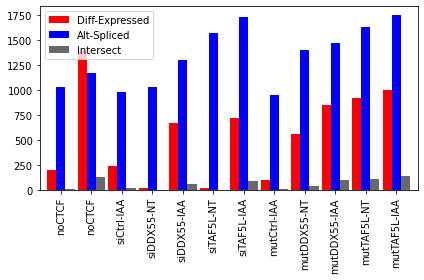

In [12]:
# common_keys = list(
#     set(de_samples).intersection(set(splice_samples))
# )
common_keys = [
#  'CTCF-noTIR1-IAA_CTCF-noTIR1',
 'noCTCF_CTCF',
 'noCTCF_CTCF-noTIR1',
 'siCtrl-IAA_siCtrl-NT',
 'siDDX55-NT_siCtrl-NT',
 'siDDX55-IAA_siCtrl-NT',
 'siTAF5L-NT_siCtrl-NT',
 'siTAF5L-IAA_siCtrl-NT',
 'mutCtrl-IAA_mutCtrl-NT',
 'mutDDX55-NT_mutCtrl-NT',
 'mutDDX55-IAA_mutCtrl-NT',
 'mutTAF5L-NT_mutCtrl-NT',
 'mutTAF5L-IAA_mutCtrl-NT',
]

ddf = pd.DataFrame([
        (k,
         len(genes_de_dict[k]),
         len(genes_spliced_dict[k]),
         len(np.intersect1d(genes_de_dict[k], genes_spliced_dict[k]))
        ) for k in common_keys ],
        columns=["sample","Diff-Expressed","Alt-Spliced","Intersect"]
)

f,ax = plt.subplots(1,figsize=(6,4),tight_layout=True)
ddf.plot.bar(ax=ax,color=["r","b","dimgrey"],width=0.9)
ax.set_xticklabels(ddf["sample"].apply(beautify_label),rotation=90);
    
plt.savefig("SuppFigure7_DE_splice_quantify.pdf")

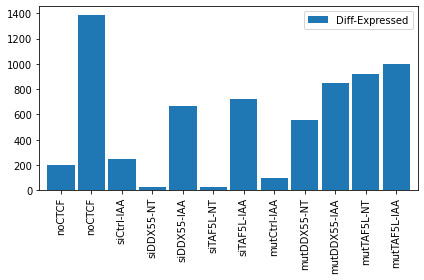

In [13]:
ddf = pd.DataFrame([
        (k,
         len(genes_de_dict[k]),
        ) for k in common_keys ],
        columns=["sample","Diff-Expressed"]
)

f,ax = plt.subplots(1,figsize=(6,4),tight_layout=True)
ddf.plot.bar(ax=ax,width=0.9)
ax.set_xticklabels(ddf["sample"].apply(beautify_label),rotation=90);

plt.savefig("SuppFigure7_DE.pdf")

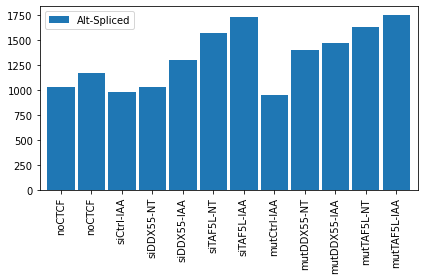

In [14]:
ddf = pd.DataFrame([
        (k,
         len(genes_spliced_dict[k]),
        ) for k in common_keys ],
        columns=["sample","Alt-Spliced"]
)

f,ax = plt.subplots(1,figsize=(6,4),tight_layout=True)
ddf.plot.bar(ax=ax,width=0.9)
ax.set_xticklabels(ddf["sample"].apply(beautify_label),rotation=90);

plt.savefig("SuppFigure7_splice.pdf")

In [15]:
! scp SuppFigure7_DE.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
! scp SuppFigure7_splice.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

SuppFigure7_DE.pdf                            100%  375KB   3.3MB/s   00:00    
SuppFigure7_splice.pdf                        100%  375KB   3.1MB/s   00:00    


#### Let's correct those numbers a bit

In [16]:
genes_spliced_corrected_dict = {k:get_genes_spliced(k) for k in splice_samples}

In [17]:
si_keys = ['siCtrl-IAA_siCtrl-NT',
         'siDDX55-NT_siCtrl-NT',
         'siDDX55-IAA_siCtrl-NT',
         'siTAF5L-NT_siCtrl-NT',
         'siTAF5L-IAA_siCtrl-NT']

for k in si_keys:
    _control_genes = genes_spliced_dict["siCtrl-NT_CTCF"]
    genes_spliced_corrected_dict[k] = list(set(genes_spliced_corrected_dict[k]) - set(_control_genes))

# AAVS really ...
mut_keys = ['mutCtrl-IAA_mutCtrl-NT',
 'mutDDX55-NT_mutCtrl-NT',
 'mutDDX55-IAA_mutCtrl-NT',
 'mutTAF5L-NT_mutCtrl-NT',
 'mutTAF5L-IAA_mutCtrl-NT']

for k in mut_keys:
    _control_genes = genes_spliced_dict["mutCtrl-NT_CTCF"]
    genes_spliced_corrected_dict[k] = list(set(genes_spliced_corrected_dict[k]) - set(_control_genes))
   
aux_keys = ['noCTCF_CTCF','noCTCF_CTCF-noTIR1']
for k in aux_keys:
    _control_genes = genes_spliced_dict['CTCF-noTIR1-IAA_CTCF-noTIR1']
    genes_spliced_corrected_dict[k] = list(set(genes_spliced_corrected_dict[k]) - set(_control_genes))


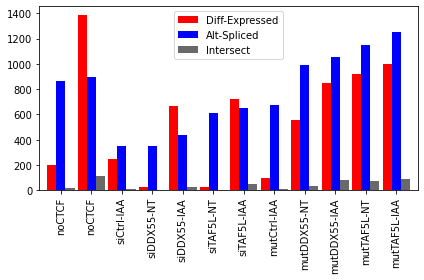

In [17]:
common_keys = [
 'noCTCF_CTCF',
 'noCTCF_CTCF-noTIR1',
 'siCtrl-IAA_siCtrl-NT',
 'siDDX55-NT_siCtrl-NT',
 'siDDX55-IAA_siCtrl-NT',
 'siTAF5L-NT_siCtrl-NT',
 'siTAF5L-IAA_siCtrl-NT',
 'mutCtrl-IAA_mutCtrl-NT',
 'mutDDX55-NT_mutCtrl-NT',
 'mutDDX55-IAA_mutCtrl-NT',
 'mutTAF5L-NT_mutCtrl-NT',
 'mutTAF5L-IAA_mutCtrl-NT',
]

ddf = pd.DataFrame([
        (k,
         len(genes_de_dict[k]),
         len(genes_spliced_corrected_dict[k]),
         len(np.intersect1d(genes_de_dict[k], genes_spliced_corrected_dict[k]))
        ) for k in common_keys ],
        columns=["sample","Diff-Expressed","Alt-Spliced","Intersect"]
)

f,ax = plt.subplots(1,figsize=(6,4),tight_layout=True)
ddf.plot.bar(ax=ax,color=["r","b","dimgrey"],width=0.9)
ax.set_xticklabels(ddf["sample"].apply(beautify_label),rotation=90);
    
plt.savefig("SuppFigure7_DE_splice_quantify_CORRECTED.pdf")


In [76]:
! scp SuppFigure7_DE_splice_quantify.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/
! scp SuppFigure7_DE_splice_quantify_CORRECTED.pdf ghpcc:/nl/umw_job_dekker/users/sv49w/ALV2021/

SuppFigure7_DE_splice_quantify.pdf            100%  375KB 436.8KB/s   00:00    
SuppFigure7_DE_splice_quantify_CORRECTED.pdf  100%  375KB 442.4KB/s   00:00    


In [18]:
[k for k in splice_samples if ("mut" in k)]

['mutCtrl-IAA_mutCtrl-NT',
 'mutDDX55-IAA_mutCtrl-IAA',
 'mutTAF5L-IAA_mutCtrl-IAA',
 'mutDDX55-IAA_mutCtrl-NT',
 'mutDDX55-NT_mutCtrl-NT',
 'mutTAF5L-IAA_mutCtrl-NT',
 'mutTAF5L-NT_mutCtrl-NT',
 'mutCtrl-NT_CTCF']

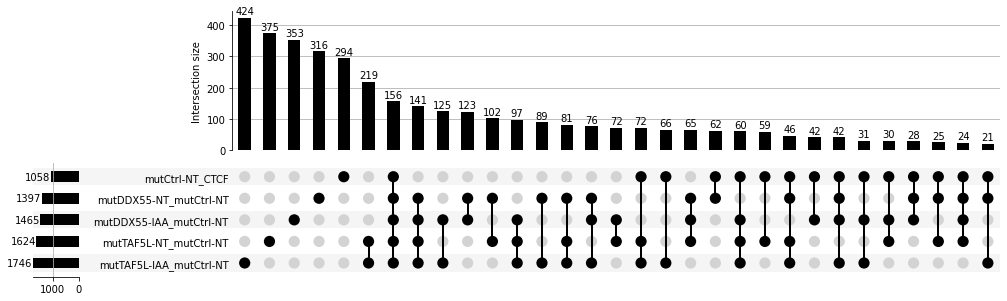

In [19]:
# _df = upsetplot.from_contents({k:get_genes_spliced(k) for k in [k for k in splice_samples if ("mut" in k)and(k!='mutCtrl-IAA_mutCtrl-NT')and("mutCtrl-IAA"not in k)]})
_df = upsetplot.from_contents({k:get_genes_spliced(k) for k in [k for k in splice_samples if ("mut" in k)and("mutCtrl-IAA"not in k)]})
# _df = upsetplot.from_contents({k:get_genes_spliced(k) for k in ['mutCtrl-NT_CTCF','mutCtrl-IAA_mutCtrl-NT']})
# _df = upsetplot.from_contents({k:get_genes_spliced(k) for k in ['mutCtrl-NT_CTCF','mutTAF5L-NT_mutCtrl-NT']})
plt = upsetplot.UpSet(_df, subset_size='count',sort_by='cardinality', show_counts=True, min_subset_size=2).plot()

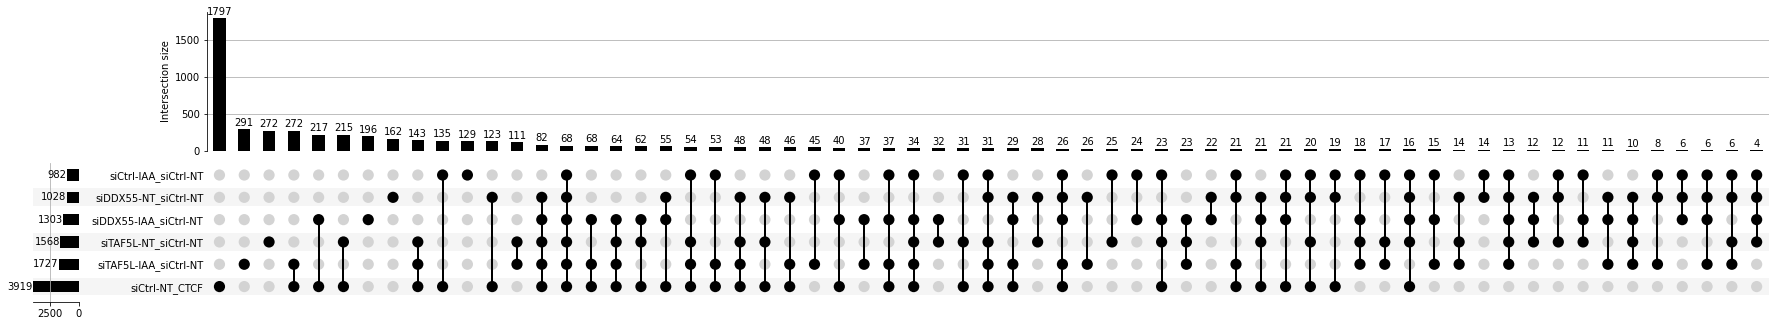

In [20]:
_df = upsetplot.from_contents({k:get_genes_spliced(k) for k in [k for k in splice_samples if ("si" in k)and("NT" in k)]})
# _df = upsetplot.from_contents({k:get_genes_spliced(k) for k in ['CTCF-noTIR1-IAA_CTCF-noTIR1','siTAF5L-IAA_siCtrl-NT', 'siCtrl-IAA_siCtrl-NT']})
plt = upsetplot.UpSet(_df, subset_size='count',sort_by='cardinality', show_counts=True, min_subset_size=2).plot()

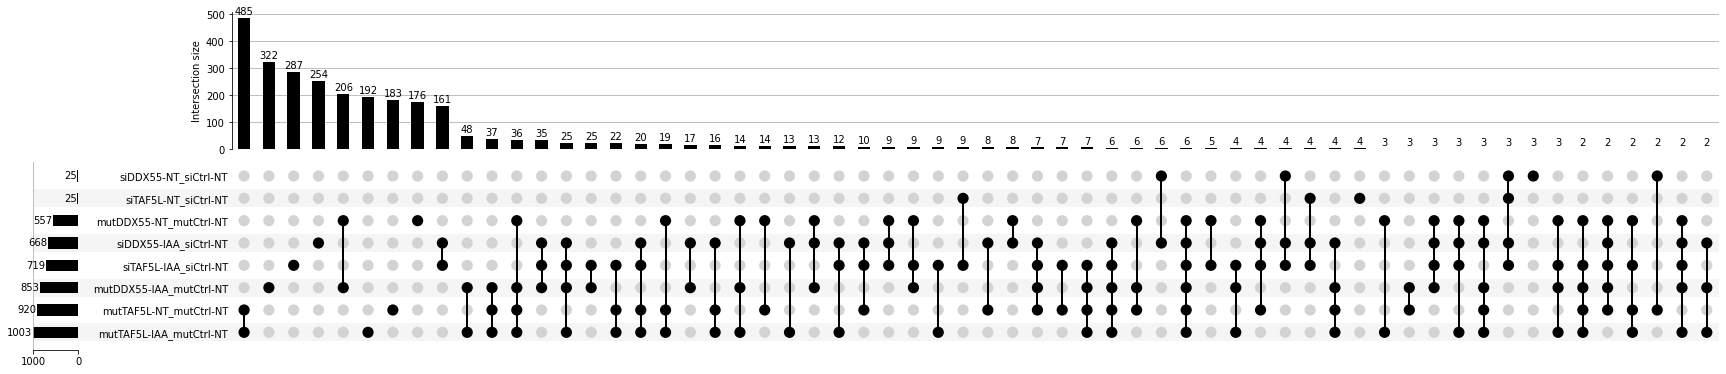

In [21]:
# _df = upsetplot.from_contents({k:get_genes_de(k) for k in [k for k in de_samples ]})
_df = upsetplot.from_contents({k:get_genes_de(k) for k in [k for k in de_samples if ("TAF" in k)or("DDX" in k)]})
plt = upsetplot.UpSet(_df, subset_size='count',sort_by='cardinality', show_counts=True, min_subset_size=2).plot()

In [122]:
_df_dict = {}
for k,l in genes_spliced_dict.items():
    _df_dict[k] = pd.DataFrame({k:True, "Name": l})
    

In [ ]:
for k in genes_spliced_dict:
    _df_dict[k].merge()

In [ ]:
# make a data frame for each set
mammal_df = pd.DataFrame({'mammal': True, 'Name': mammals})
herbivore_df = pd.DataFrame({'herbivore': True, 'Name': herbivores})
domesticated_df = pd.DataFrame({'domesticated': True, 'Name': domesticated})

# Merge three data frames together
animals_df = mammal_df.merge(
    herbivore_df.merge(domesticated_df, on = 'Name', how = 'outer'),
    on = 'Name', how = 'outer')

# Replace NaN with False
animals_df = animals_df.fillna(False)

# Make sets index for the data frame
animals_df = animals_df.set_index(['mammal', 'herbivore', 'domesticated'])

animals_df